In [1]:
import scanpy as sc
from xarray.ufuncs import spacing

In [2]:
adata = sc.read("data/dataset.h5ad")

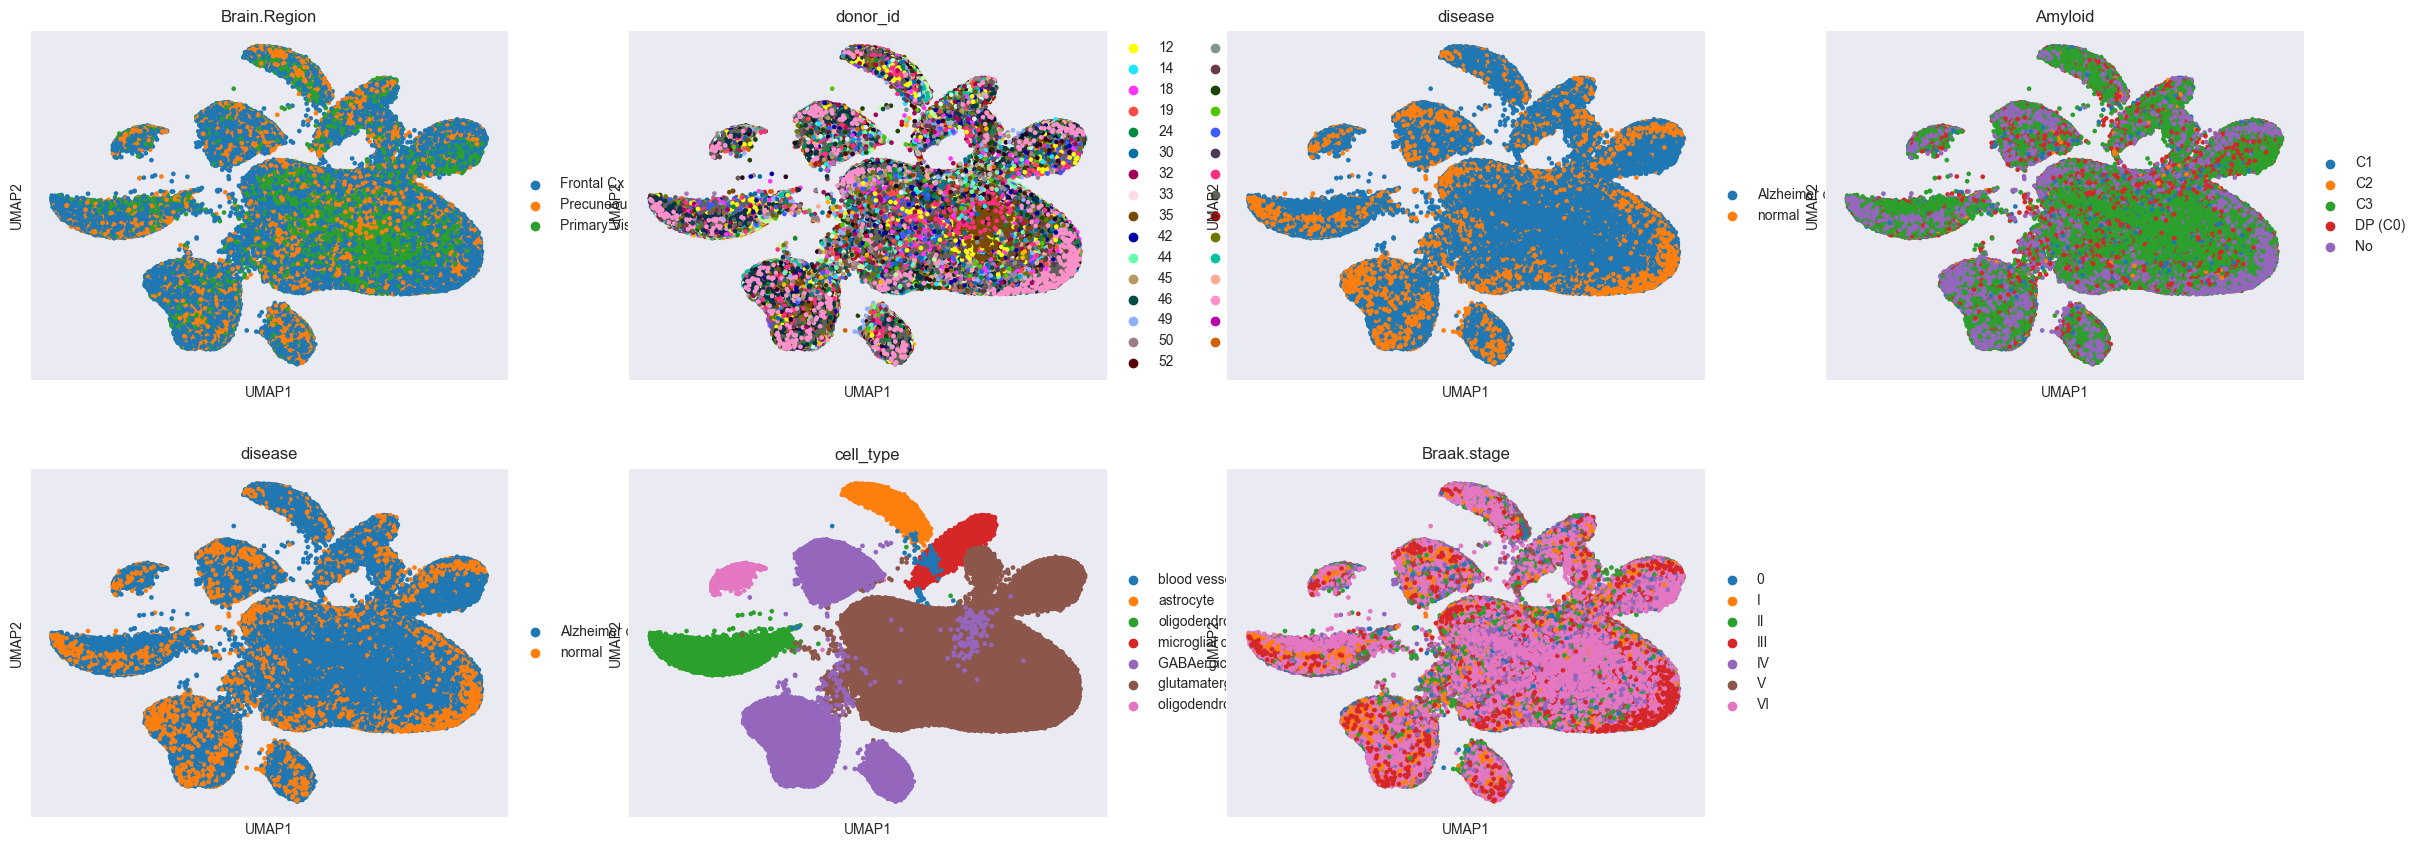

In [11]:
sc.pl.umap(adata, color = ["Brain.Region", "donor_id", "disease", "Amyloid", "disease", "cell_type", "Braak.stage"], size = 45)

In [12]:
adata = adata[adata.obs["cell_type"] == "glutamatergic neuron"]

In [ ]:
adata.layers["counts"] = adata.X.copy()
adata.layers["logcounts"] = sc.pp.log1p(adata.layers["counts"]).copy()
adata.X = adata.layers["logcounts"].copy()

/var/folders/m0/5342p_s55313vrcn64gwp8t80000gn/T/ipykernel_81271/4266669392.py:1: ImplicitModificationWarning: Setting element `.layers['counts']` of view, initializing view as actual.
  adata.layers["counts"] = adata.X.copy()
